In [1]:
import numpy as np
import matplotlib.pyplot as plt

from reeb_graph_simulation import Reeb_Graph
from reeb_aux import *

from utils import *

In [2]:
np.random.seed(17051991)

# Basic Example

We start with a basic example of a point cloud, for which we choose a thickening, impose periodic boundary conditions, producte the mapper graph and exact the circular max-flow.

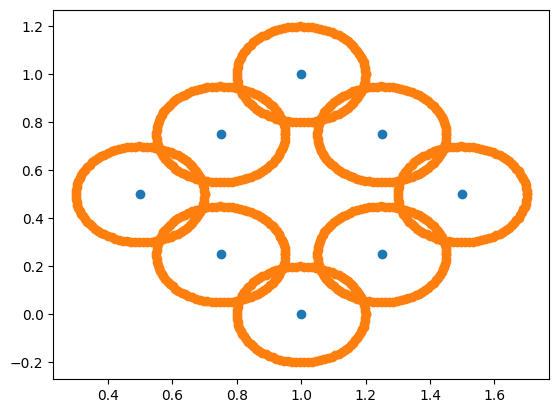

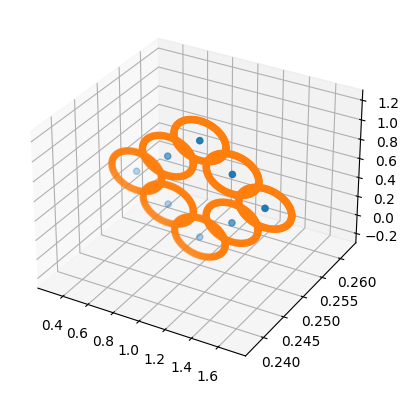

In [3]:
X = np.array([[1,0.5,0],[0.5,0.5,0.5],[1.5,0.5,0.5],[0,0.5,1],[0.5,0.5,1.5],[1.5,0.5,1.5],[2,0.5,1],[1,0.5,2]])
X = (X/np.max(X))+np.array([0.5,0,0])


# Fix the radius of the thickening
radius = 0.2


# Obtain a 2D slice of the thickening
theta = np.linspace(0,2*np.pi,100)
ball_2D = np.array([np.cos(theta),np.zeros_like(theta),np.sin(theta)]).T*radius
X_2D = np.array([p + ball_2D for p in X]).reshape(len(X)*len(theta),3)


# Plot the 2D Slice of the thickening
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X[:,0],X[:,2])
ax.scatter(X_2D[:,0],X_2D[:,2])

# Plot the 2D Slice of the thickening embedded in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2])
ax.scatter(X_2D[:,0],X_2D[:,1],X_2D[:,2])

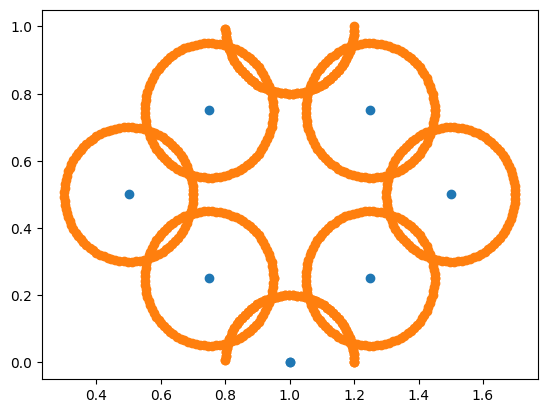

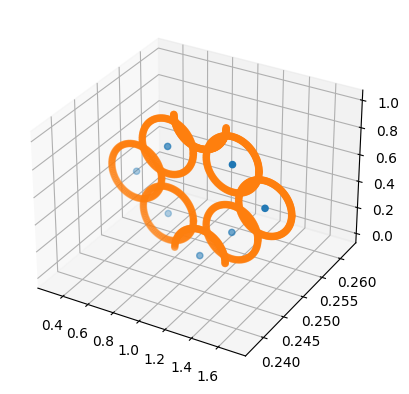

In [4]:
# Setup the box for the periodic boundary conditions
M = np.array([2,1,1],dtype=float)
m = np.array([0,0,0],dtype=float)

# Impose the periodic boundary conditions
X_r_periodic = m + np.remainder(X_2D-m, M-m)
X_periodic = m + np.remainder(X-m, M-m)


# Plot the 2D Slice of the periodic thickening
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_periodic[:,0],X_periodic[:,2])
ax.scatter(X_r_periodic[:,0],X_r_periodic[:,2])

# Plot the 2D Slice of the periodic thickening embedded in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_periodic[:,0],X_periodic[:,1],X_periodic[:,2])
ax.scatter(X_r_periodic[:,0],X_r_periodic[:,1],X_r_periodic[:,2])

In [5]:
# Setting up the parameters for building the Mapper Graph

n_grid = 101 # number of point in each dimension for the grid
r = radius

# don't change the following
fat = 1
covering = np.array([-1,1])
reeb_stride = 2
relax = [n_grid//2,-(n_grid//2+1)]
stride = 20
radii = np.ones_like(X[:,0])*r

In [6]:
reeb = Reeb_Graph(X, M = M, m = m, radii = radii,
    grid_size = n_grid, 
    periodic = True,
    fat_radius = fat,
    covering = covering,
    reeb_stride = reeb_stride,
    transform_points = None,
    swap_res_grid_and_balls = True, #if this is set to false, you use the complementary of the thickening
    relax_z_axis = relax,
    verbose = False, save_RAM = True, stride=stride, MP=False)

reeb.make_reeb_graph(plot=False)
    

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


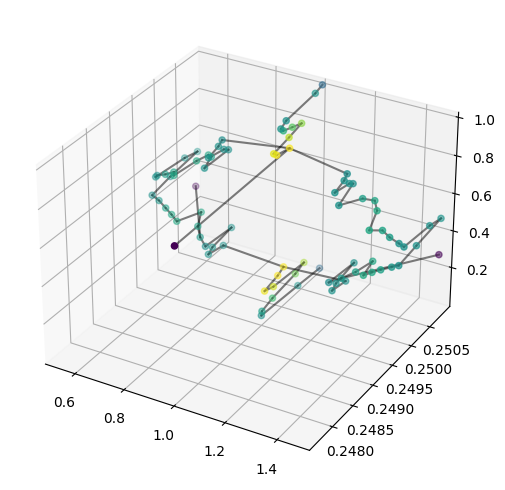

In [7]:
#Plot the Mapper Graph Embedded in 3D by taking barycenters of path connected components
reeb.plot_reeb()

/Users/ye72al/Documents/Glass_TDA/Submission/Simulation_Studies/reeb_graph.py:788: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


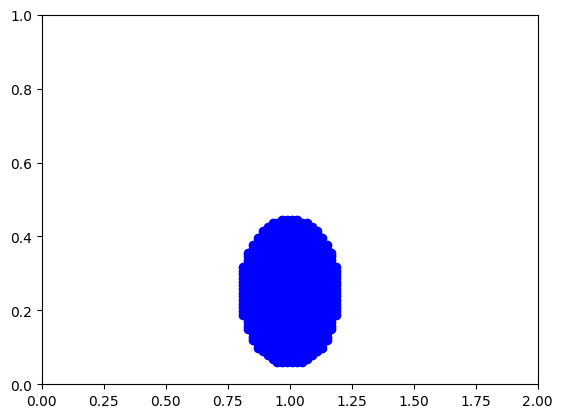

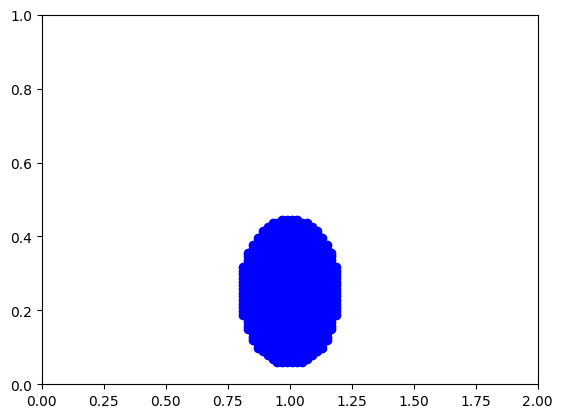

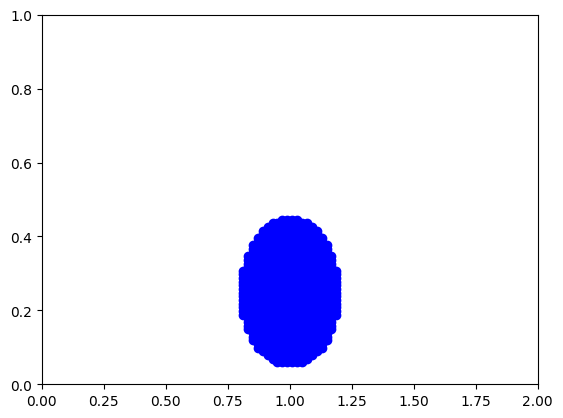

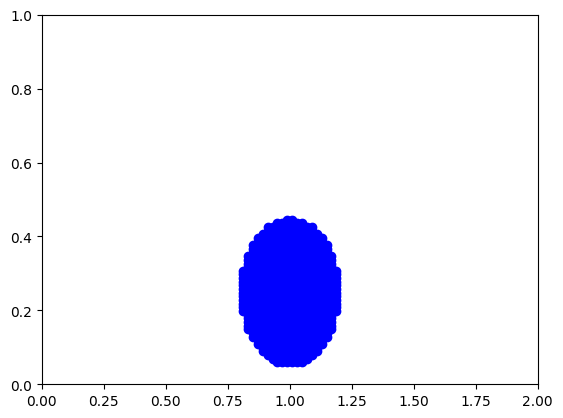

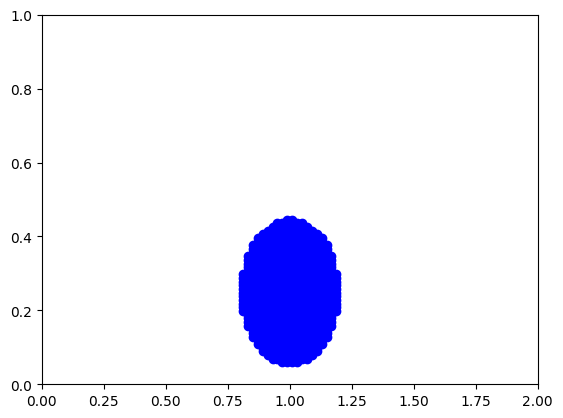

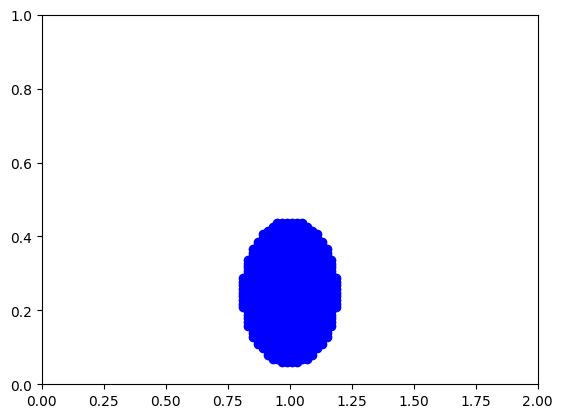

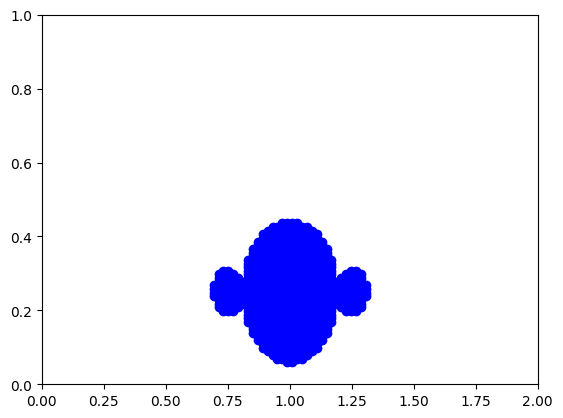

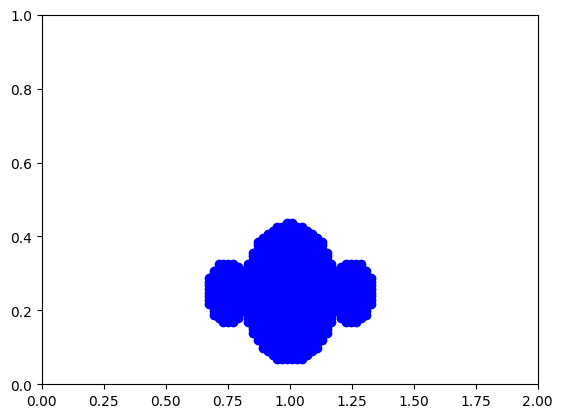

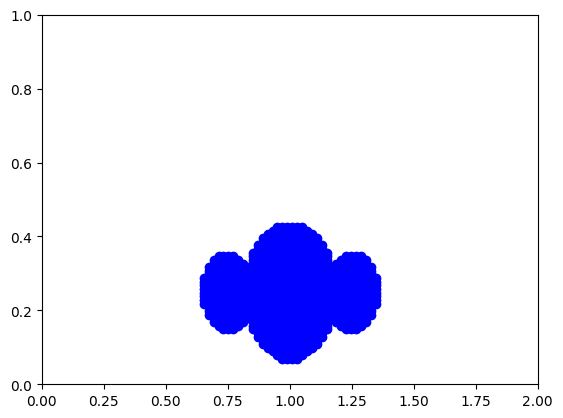

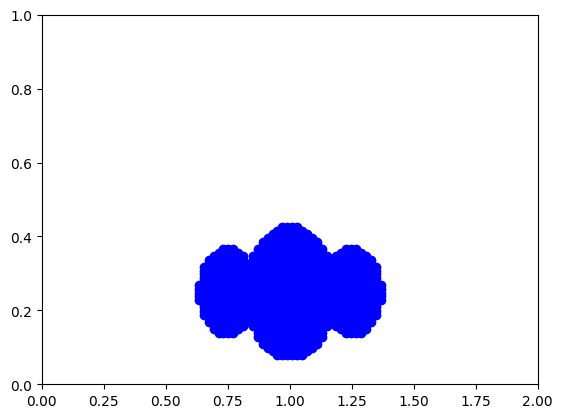

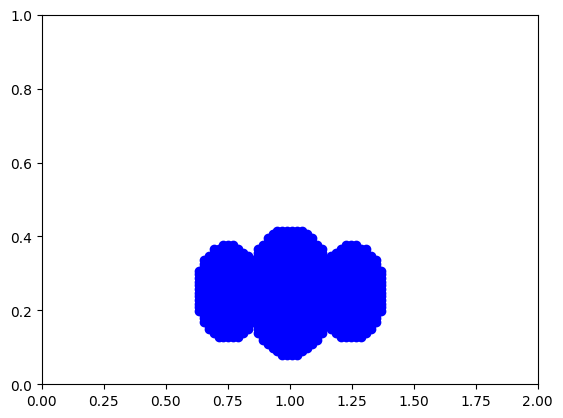

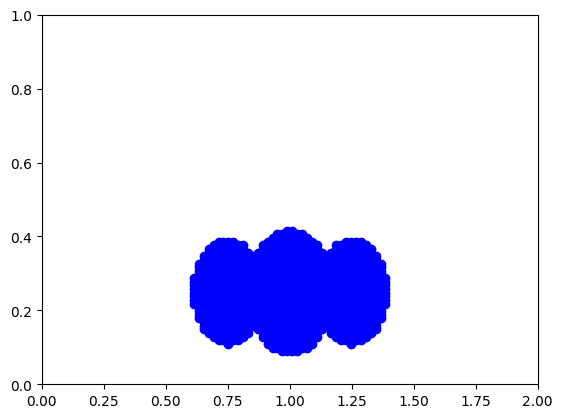

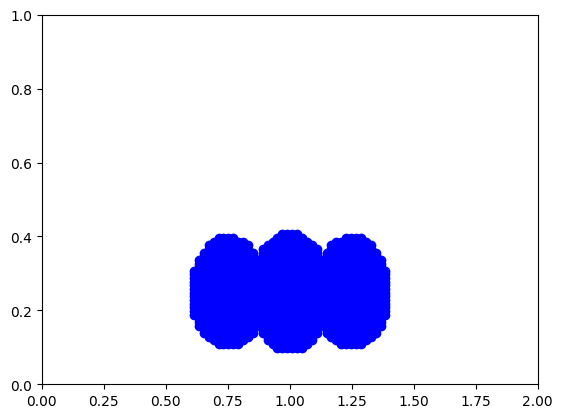

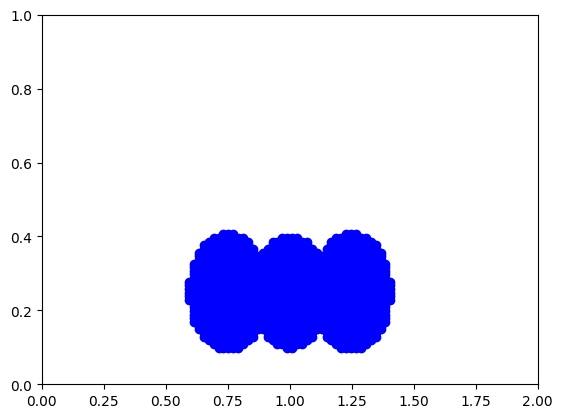

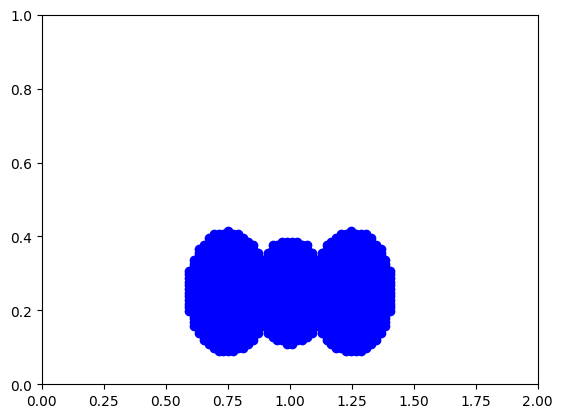

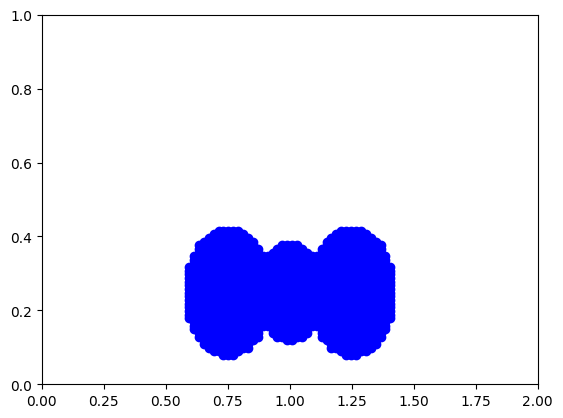

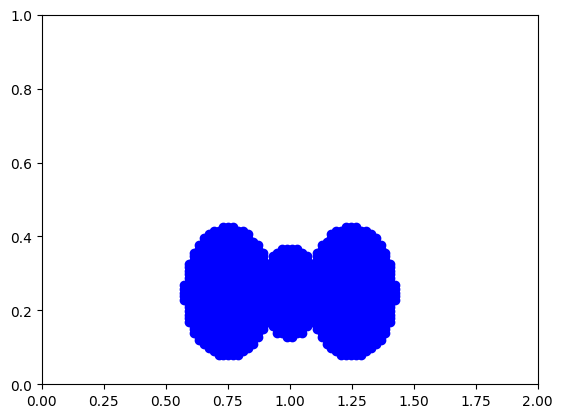

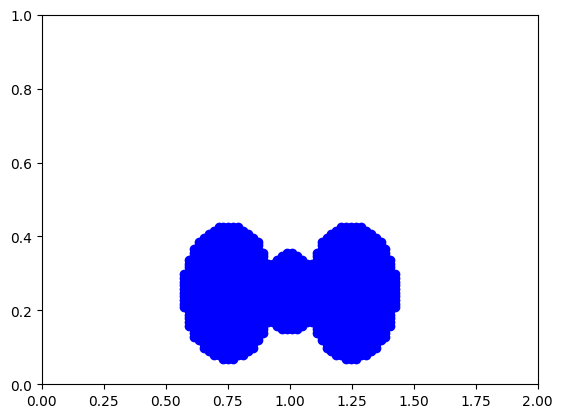

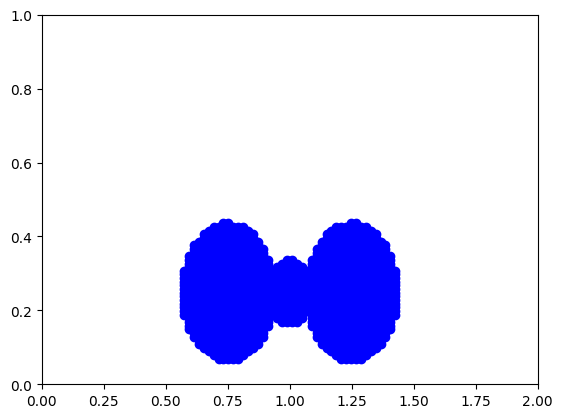

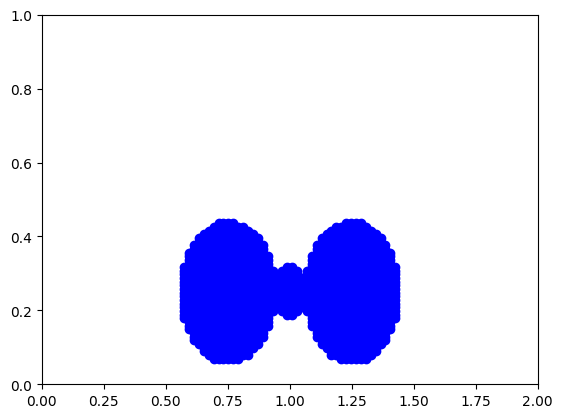

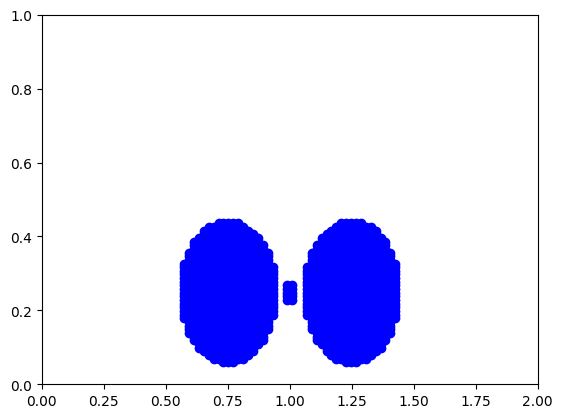

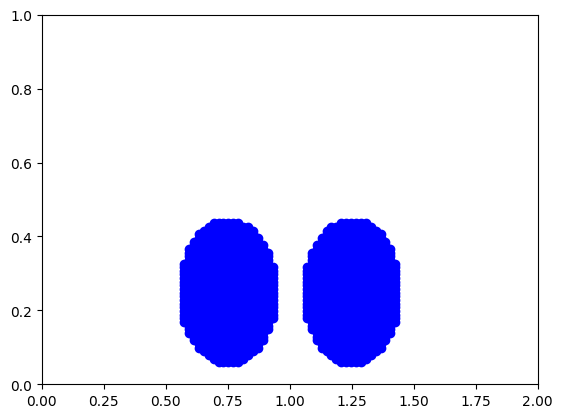

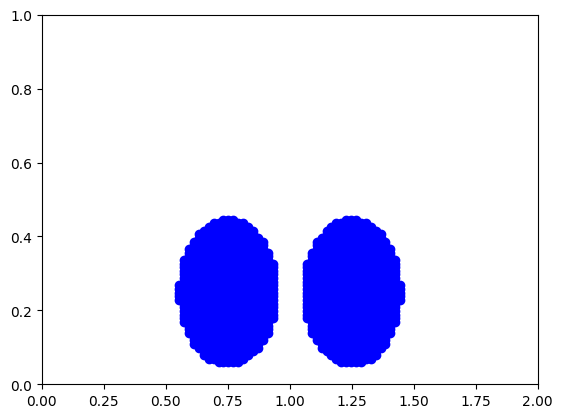

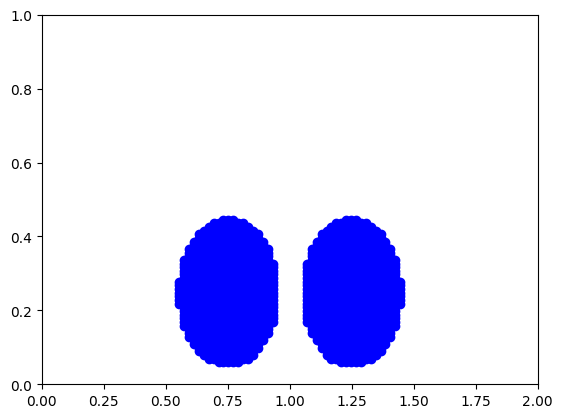

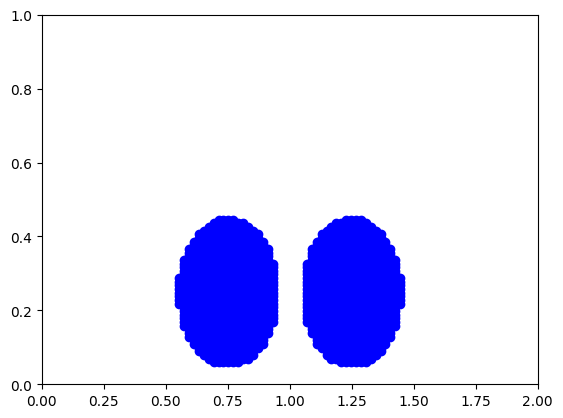

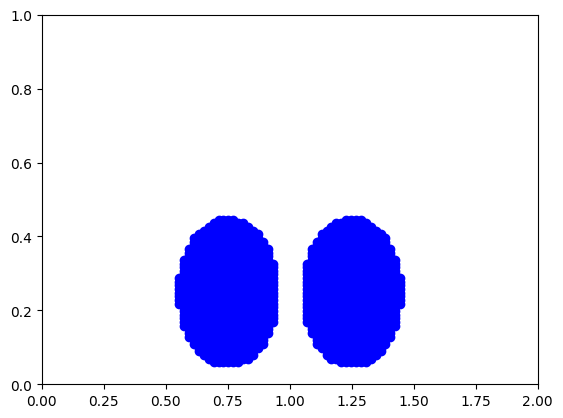

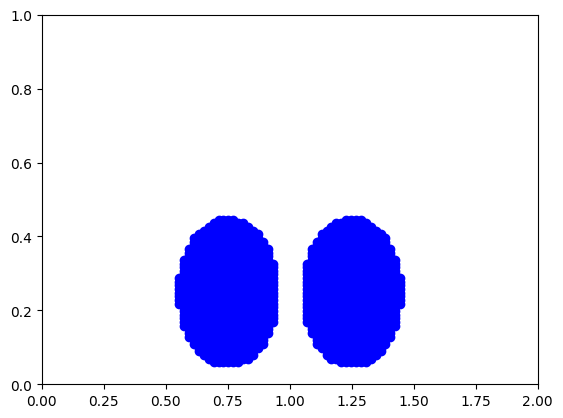

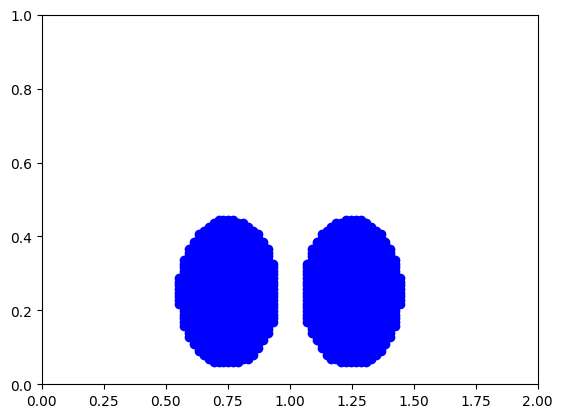

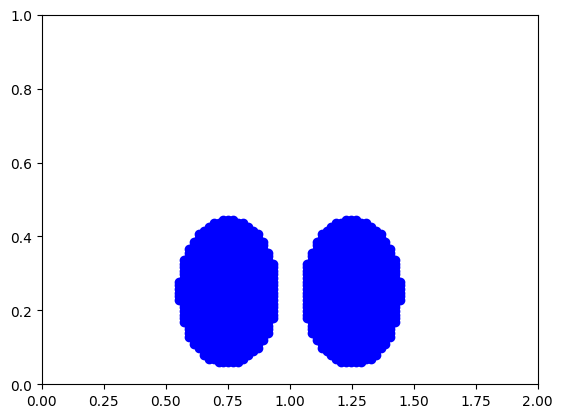

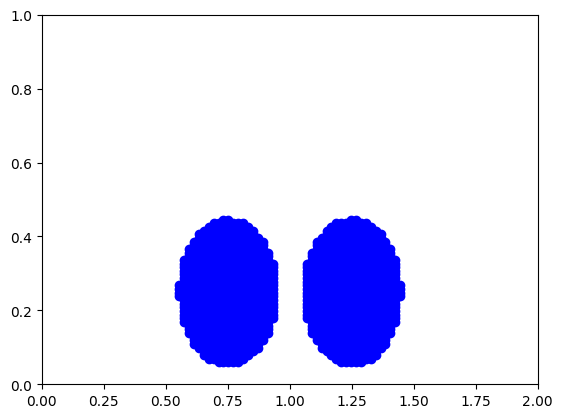

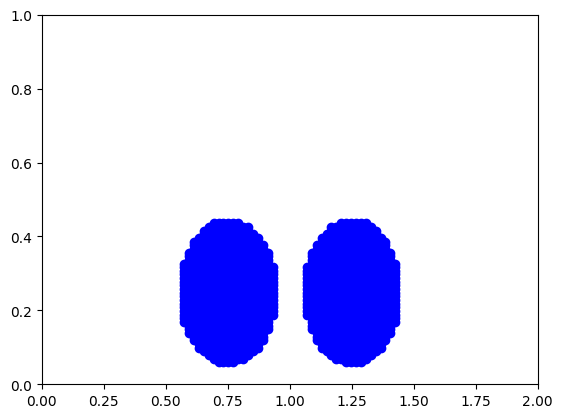

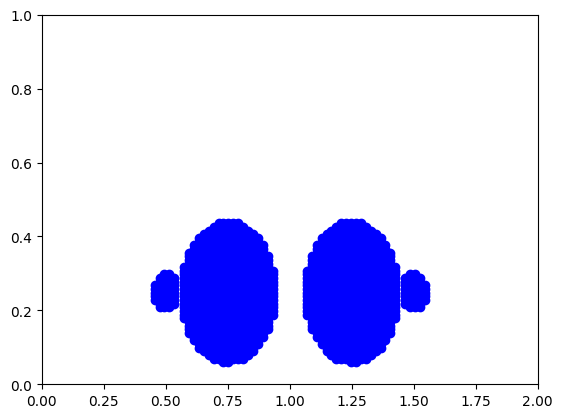

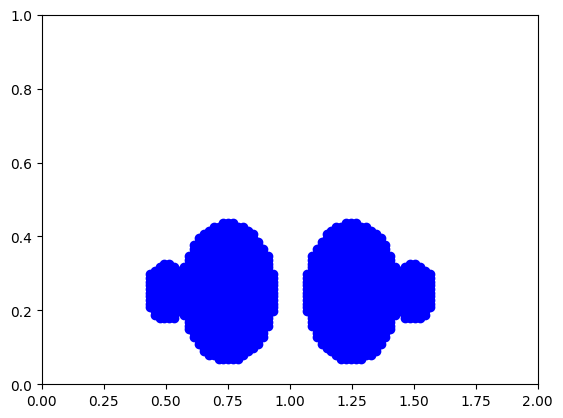

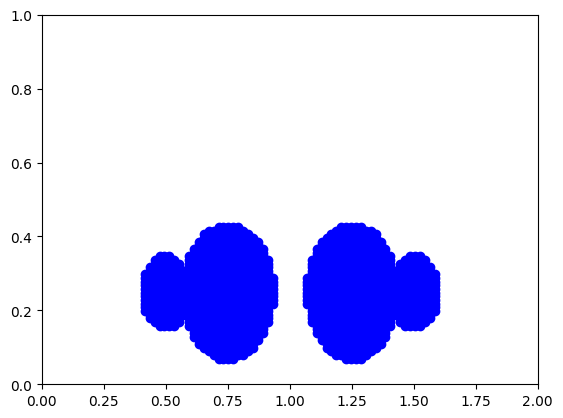

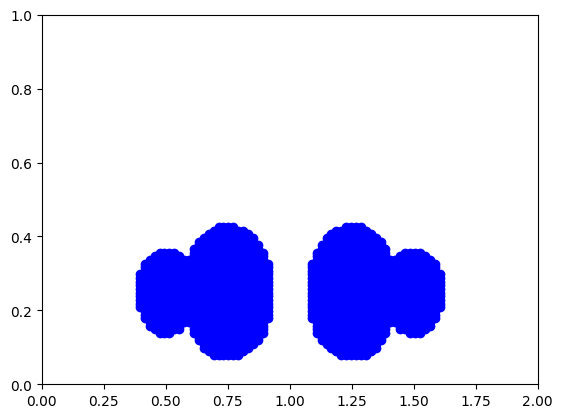

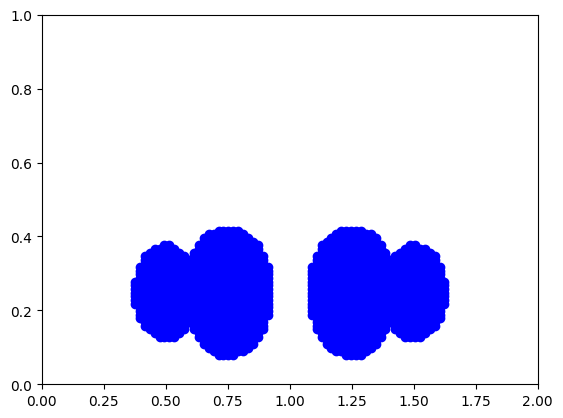

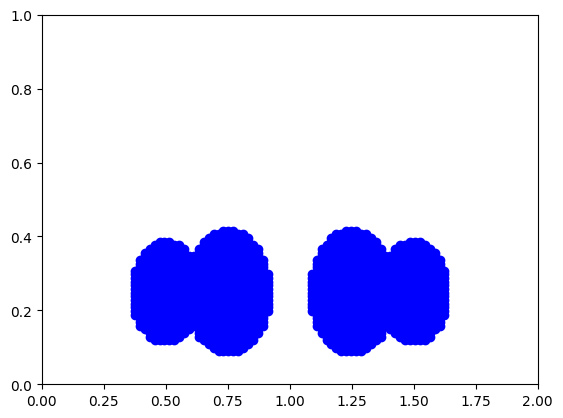

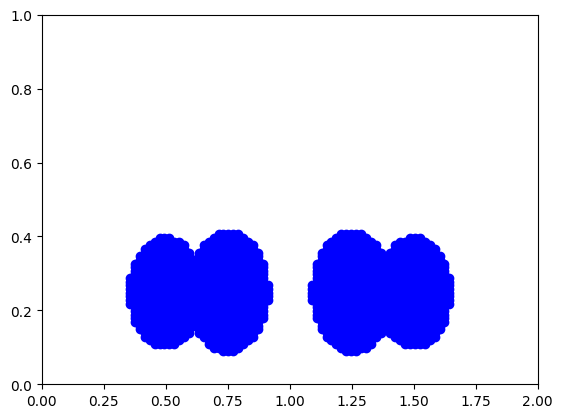

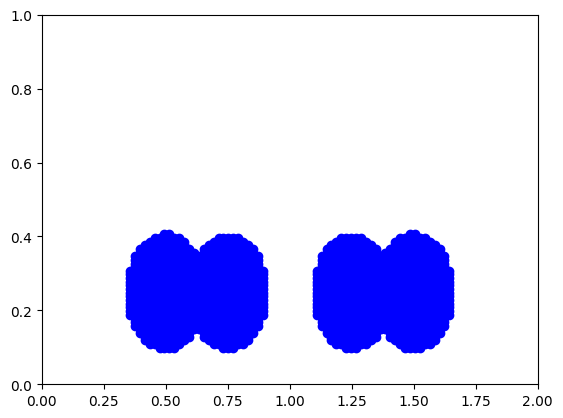

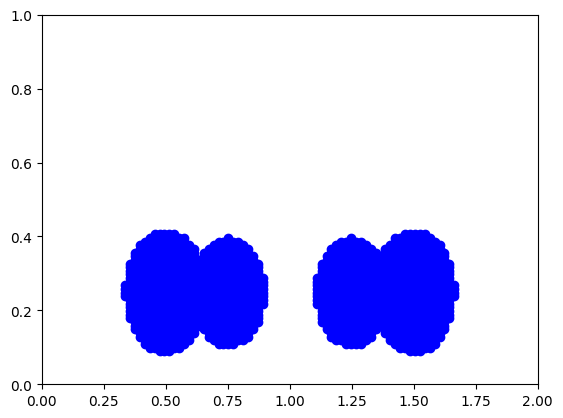

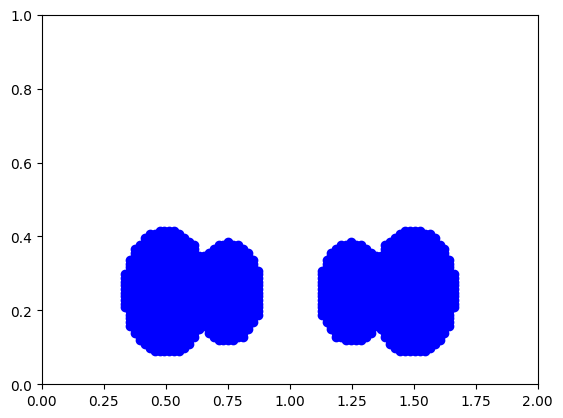

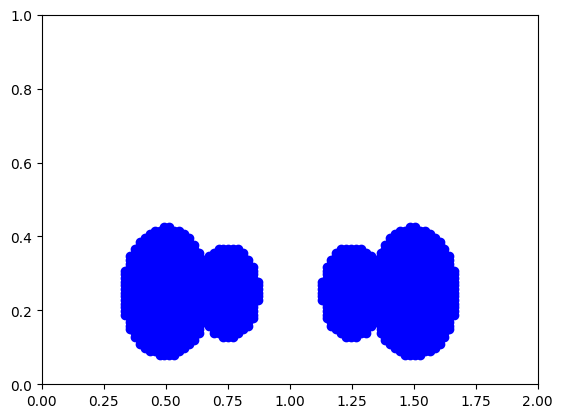

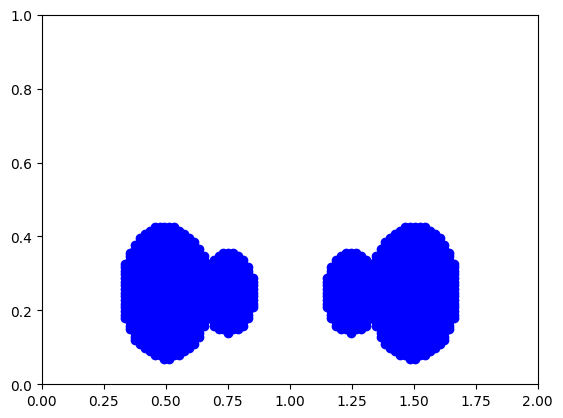

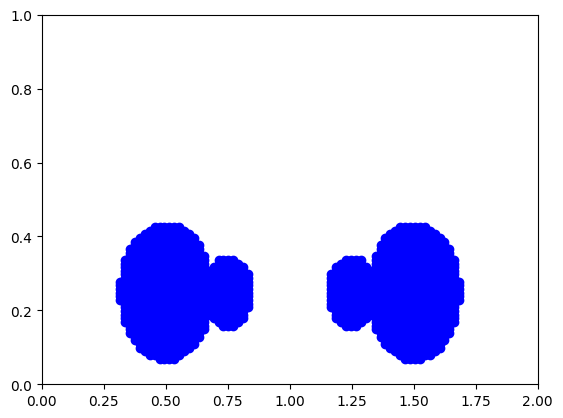

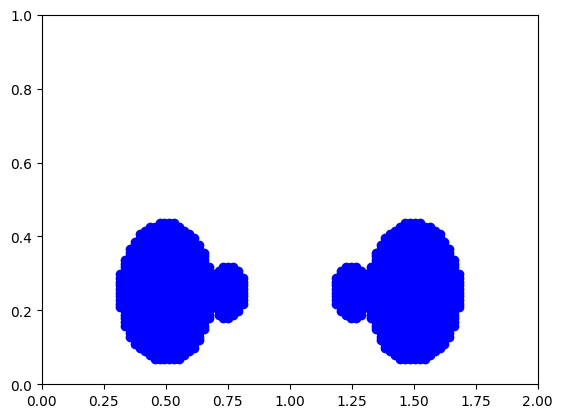

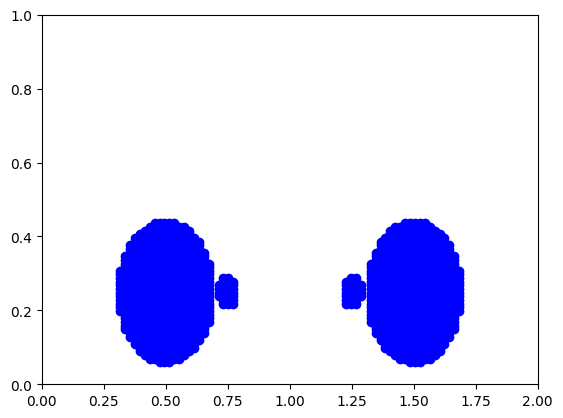

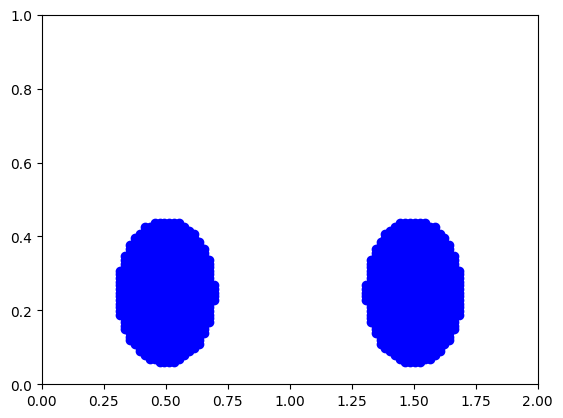

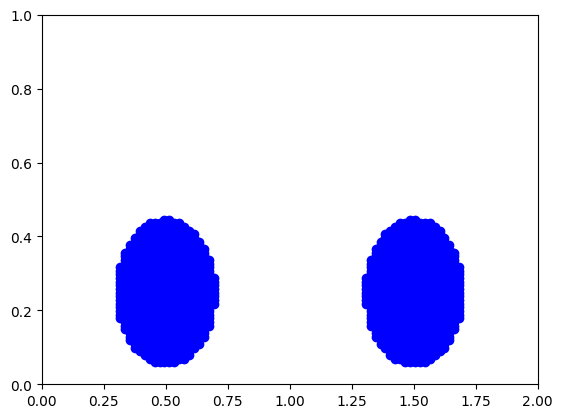

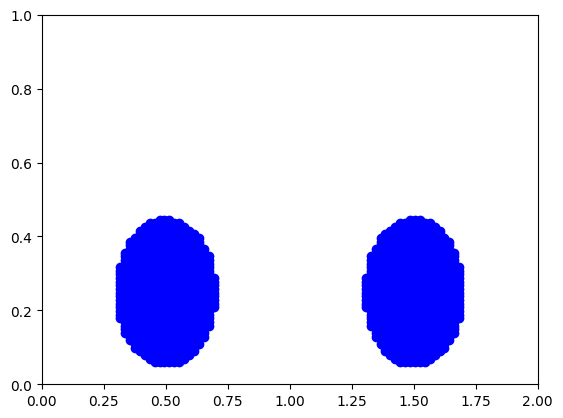

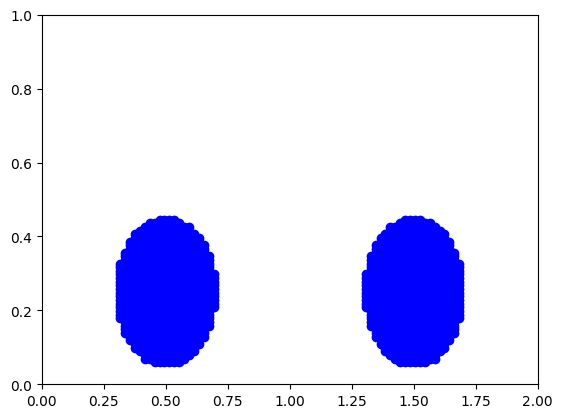

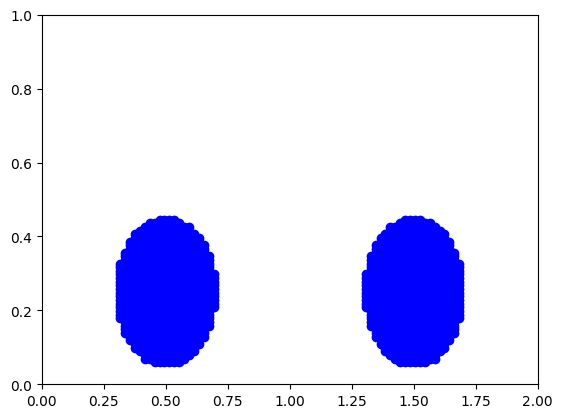

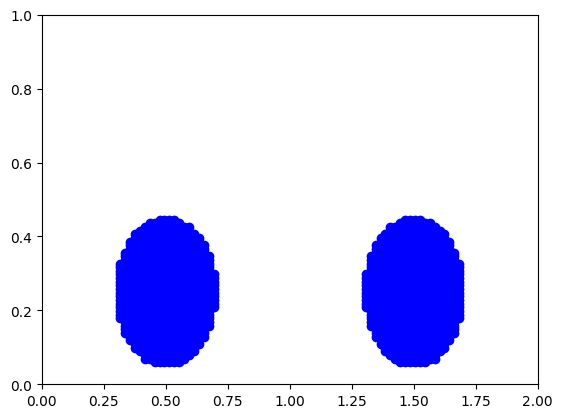

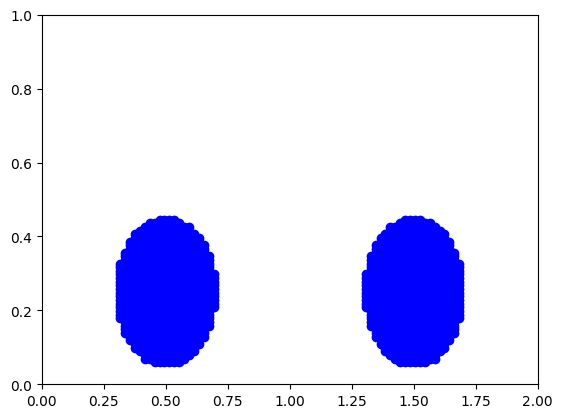

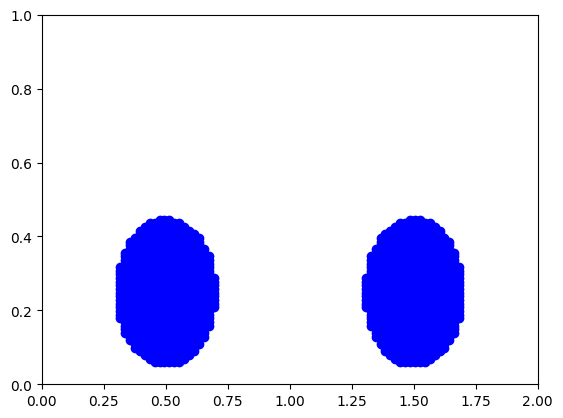

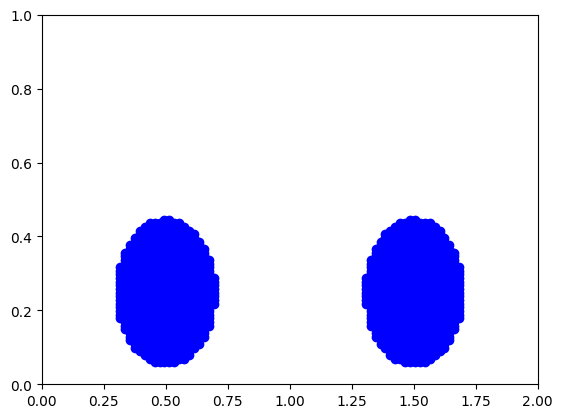

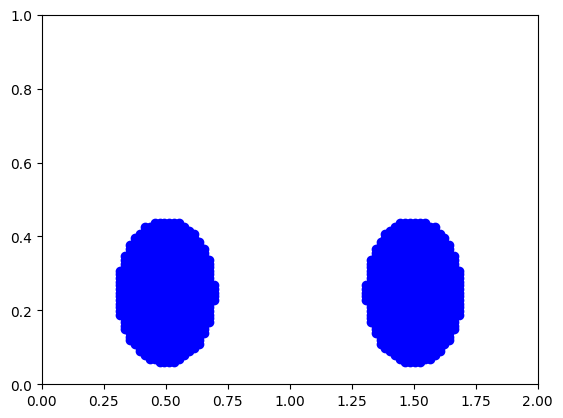

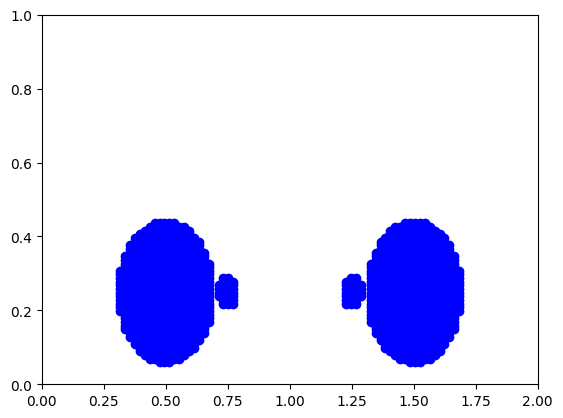

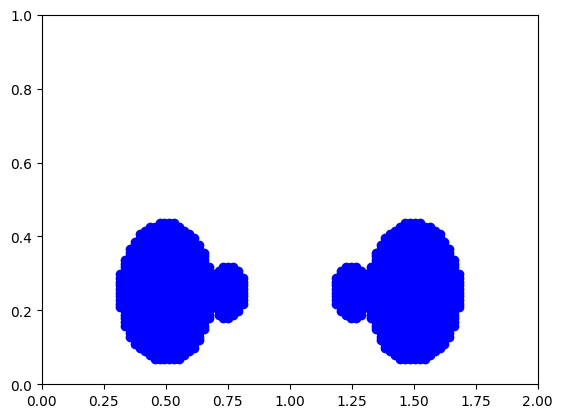

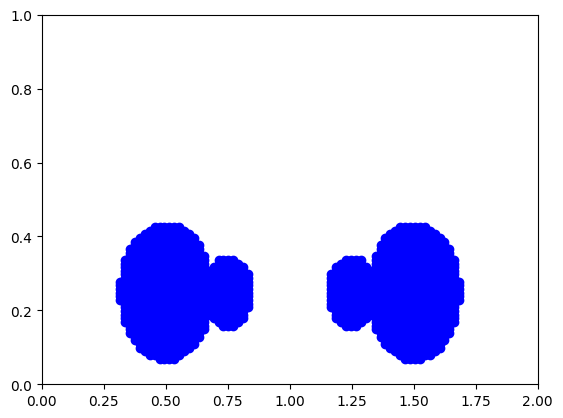

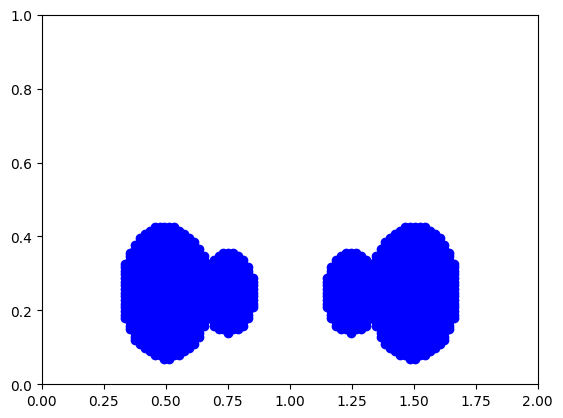

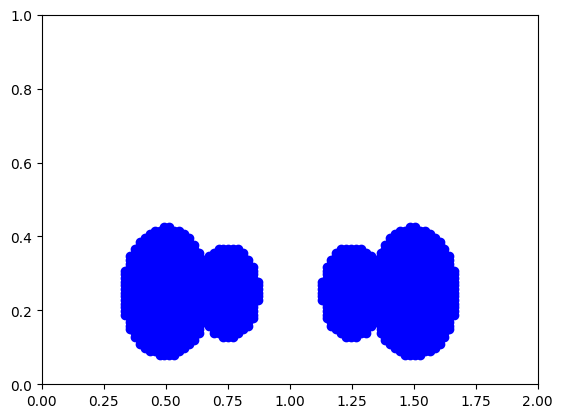

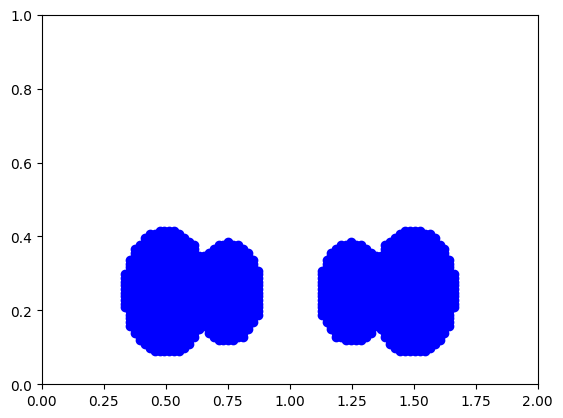

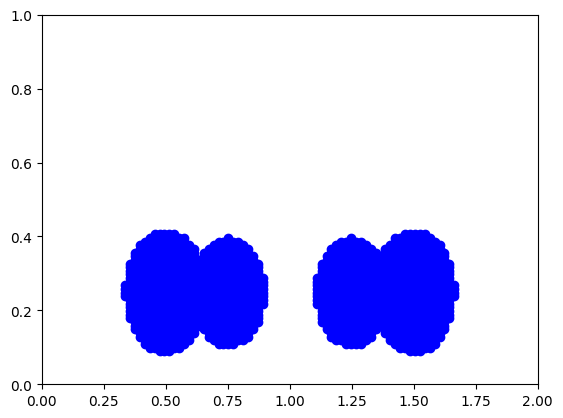

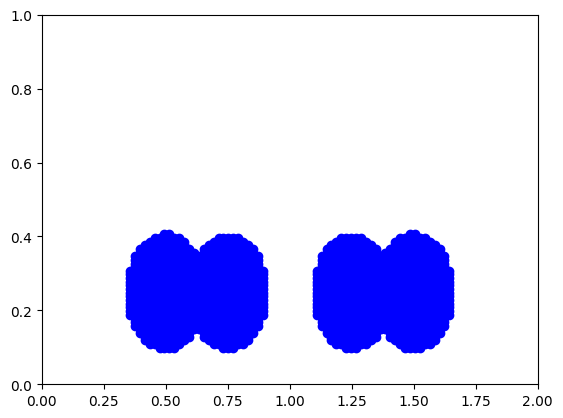

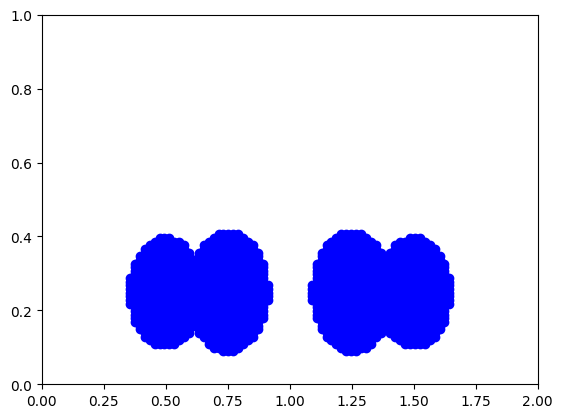

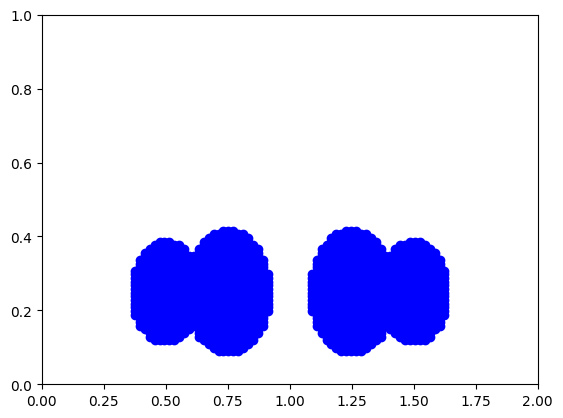

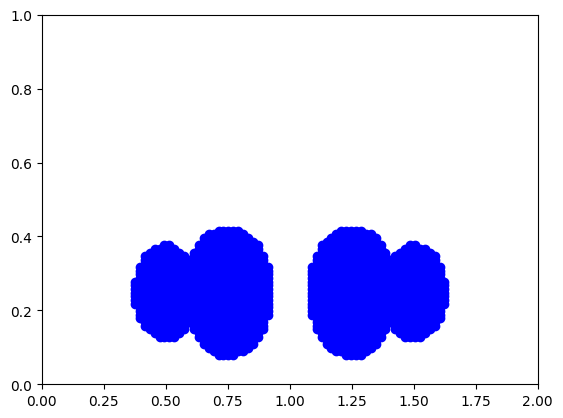

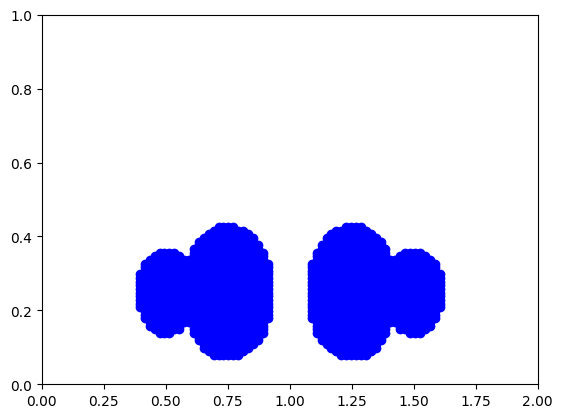

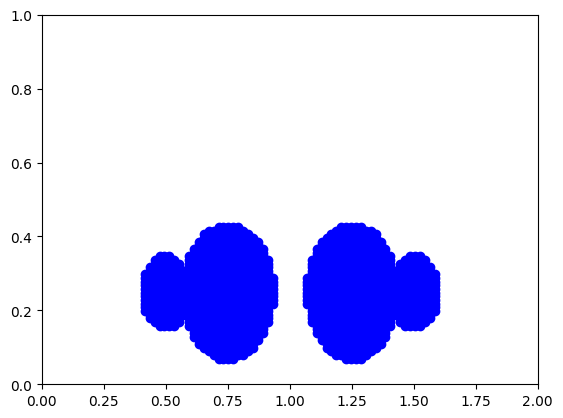

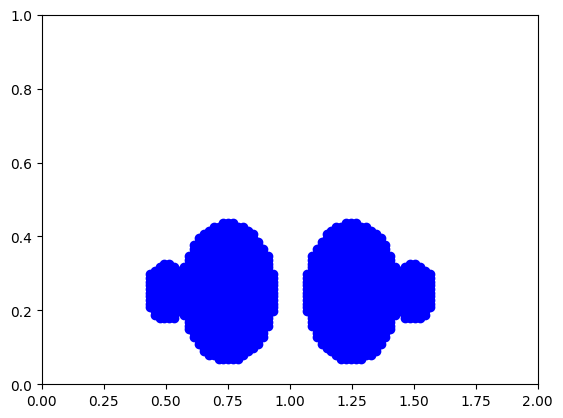

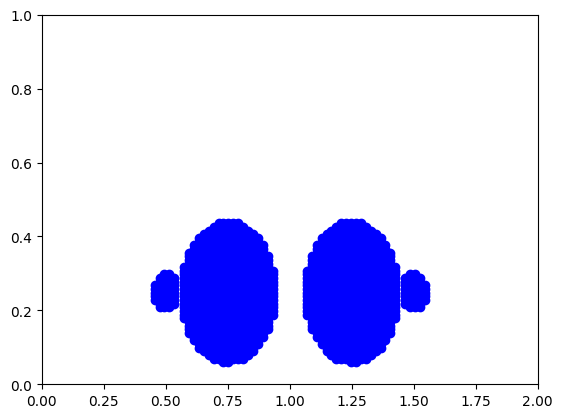

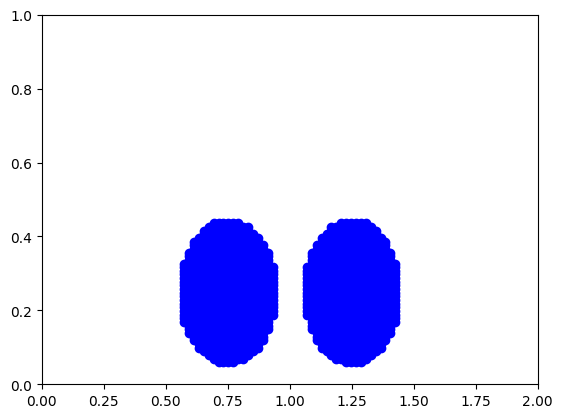

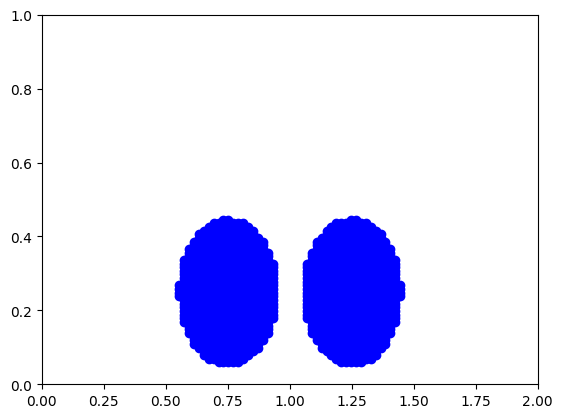

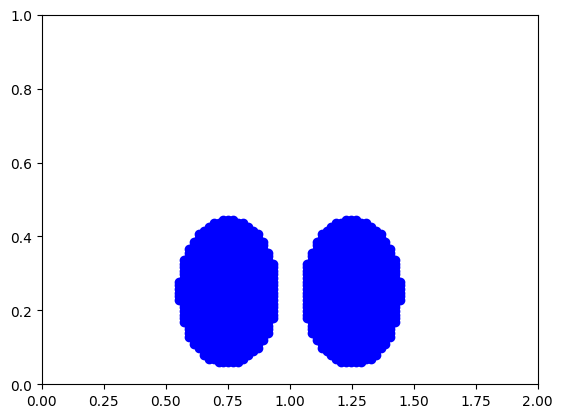

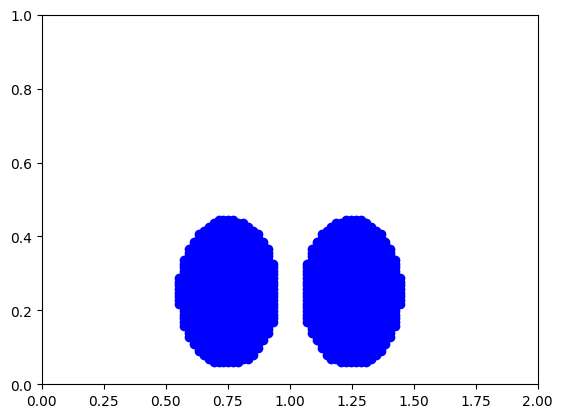

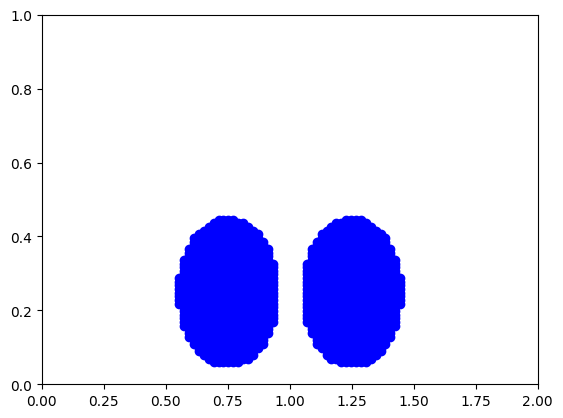

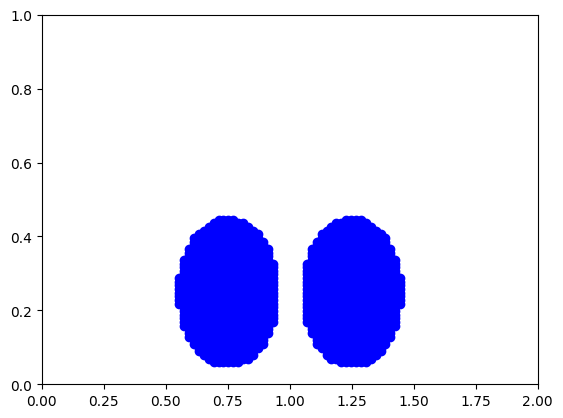

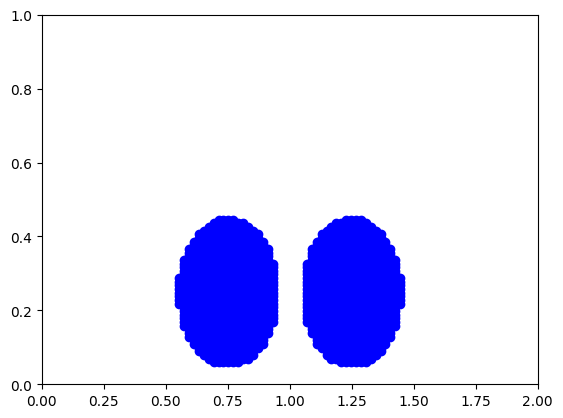

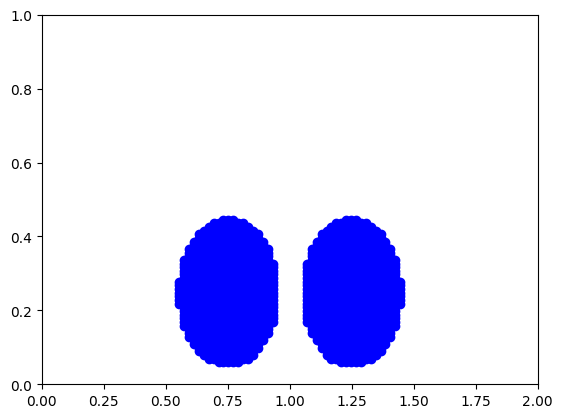

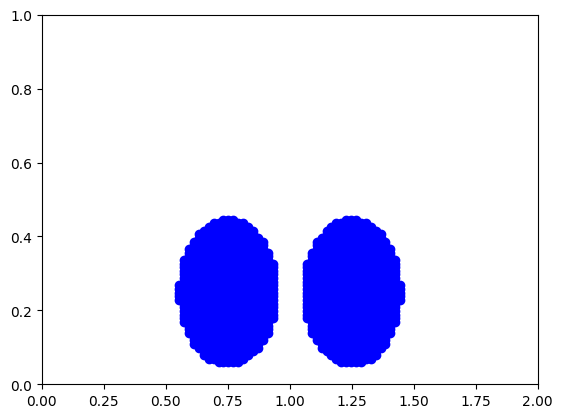

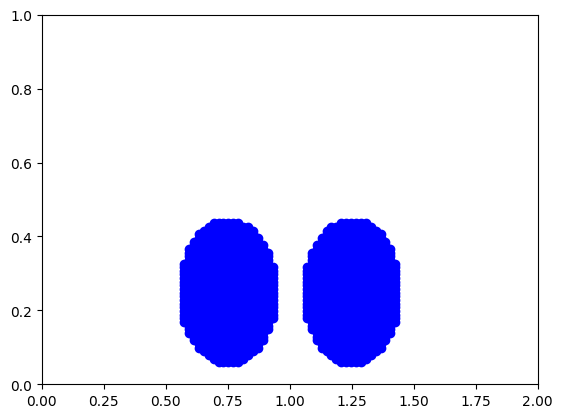

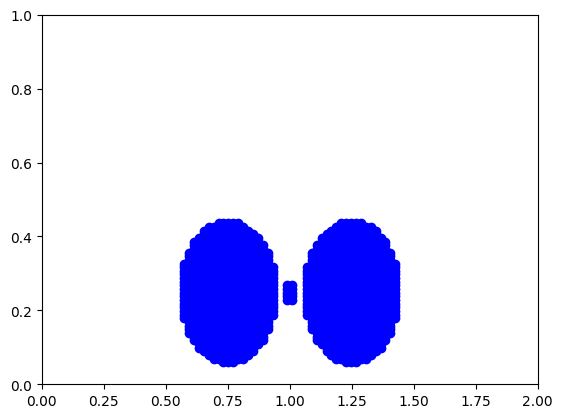

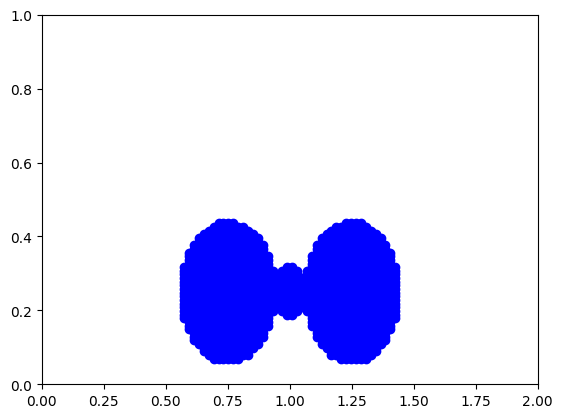

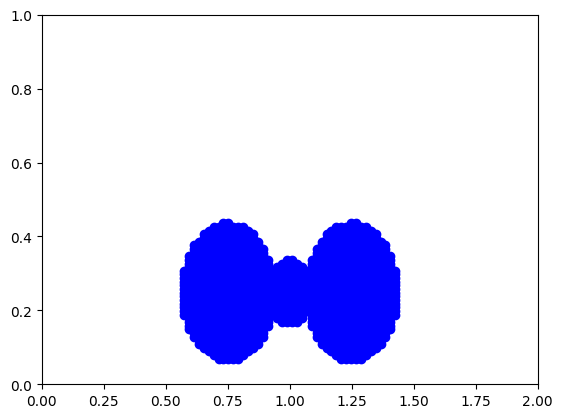

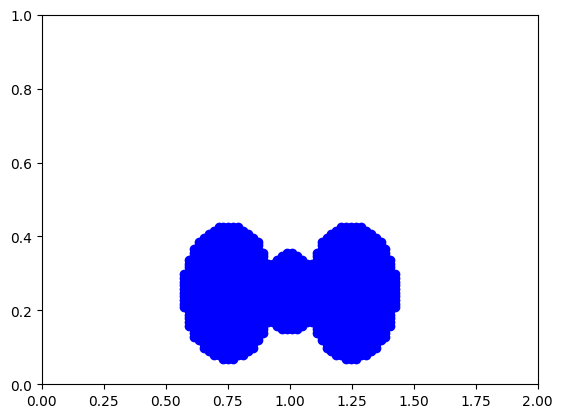

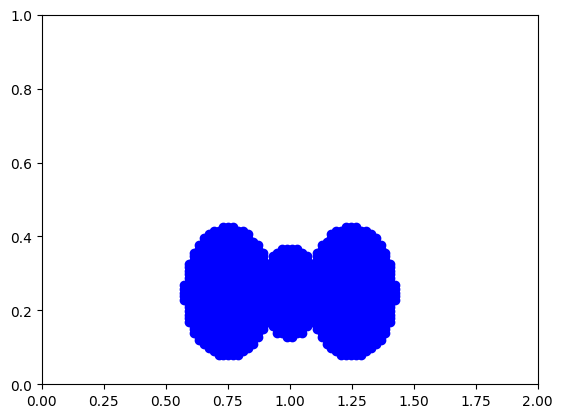

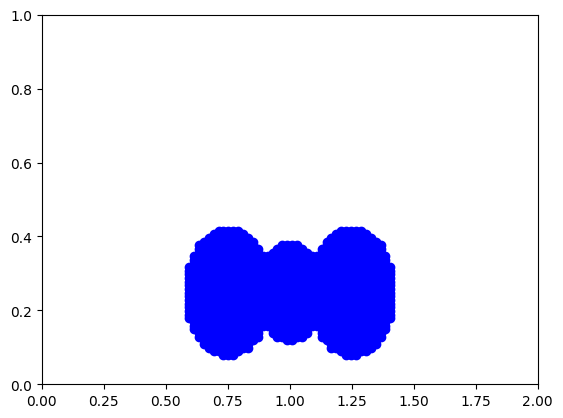

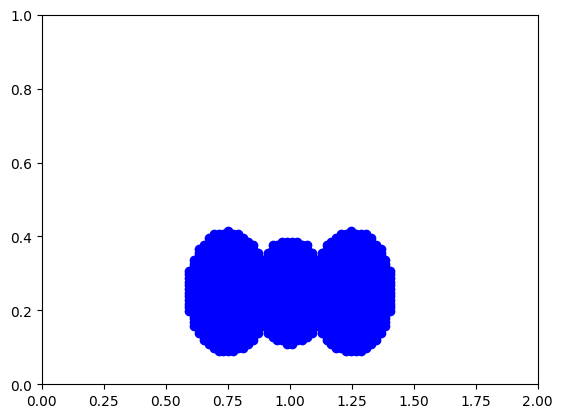

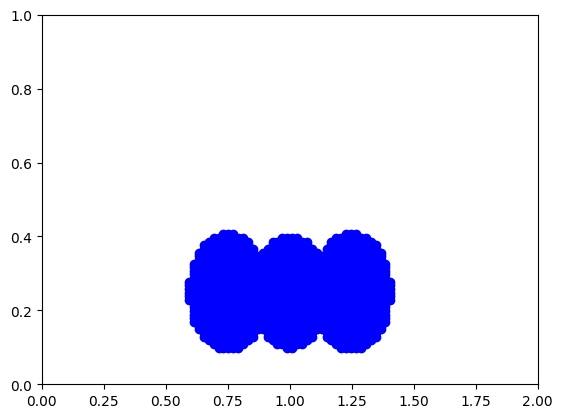

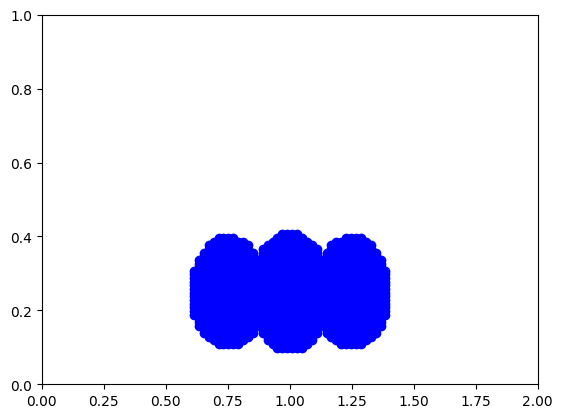

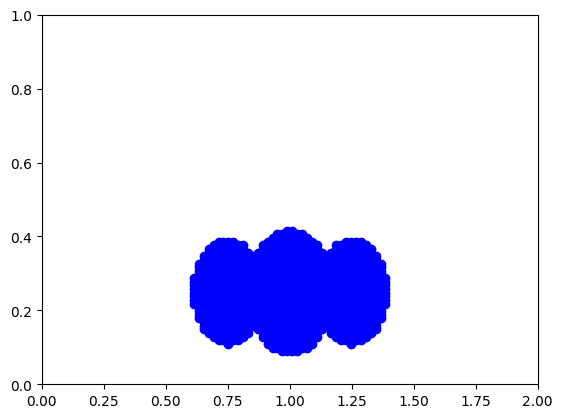

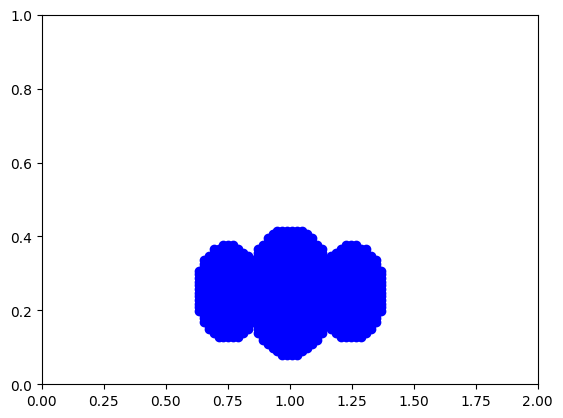

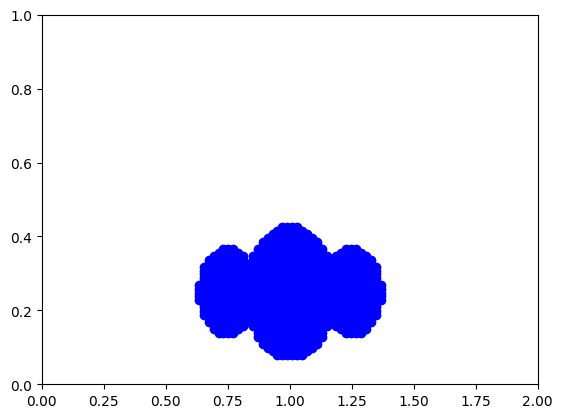

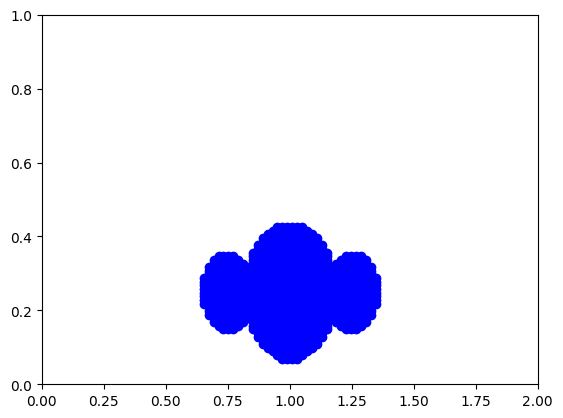

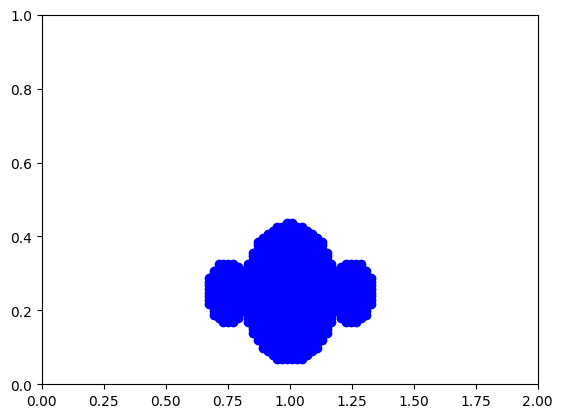

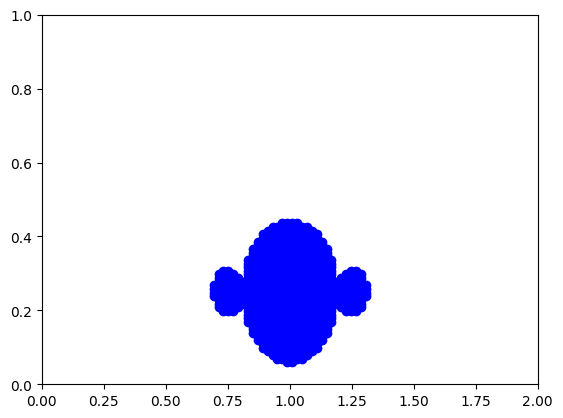

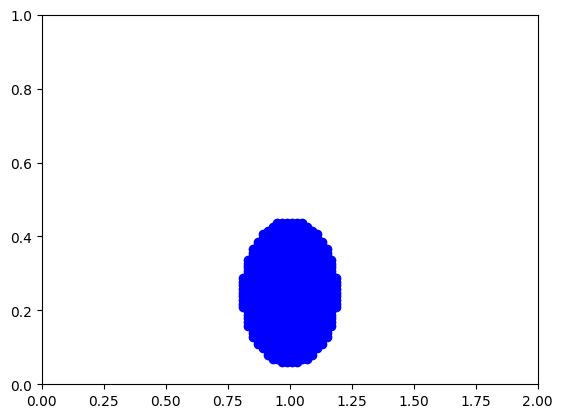

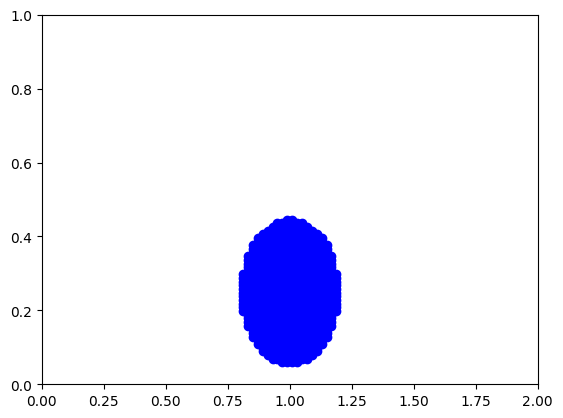

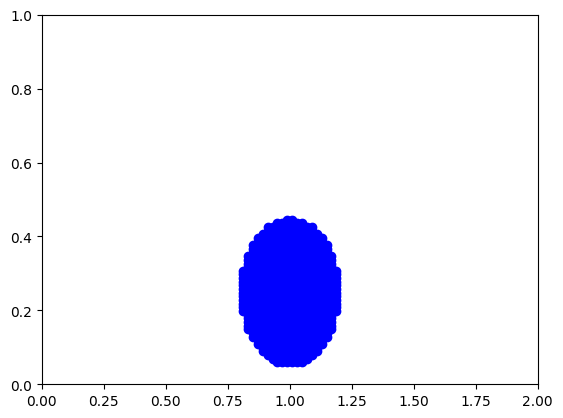

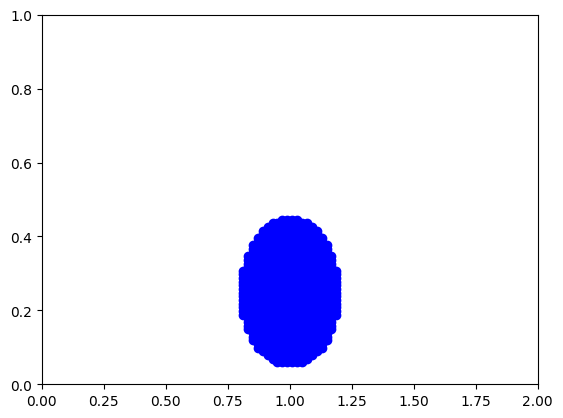

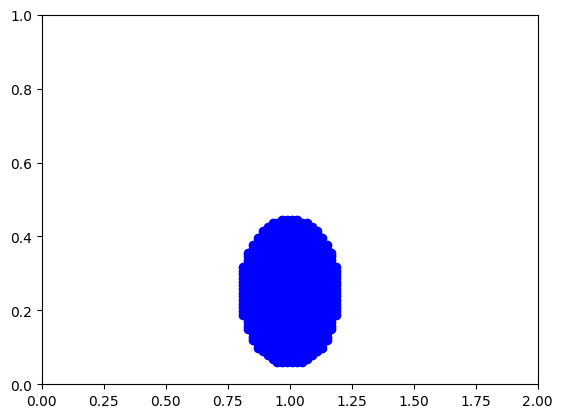

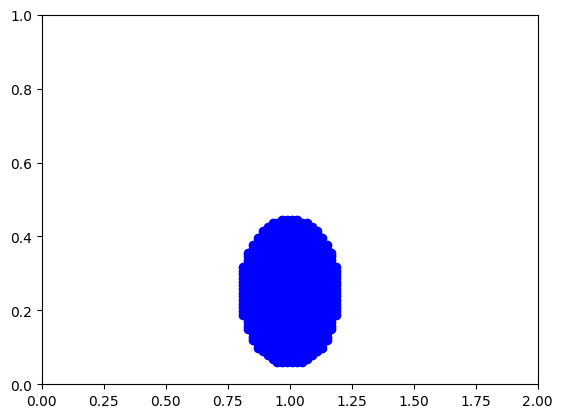

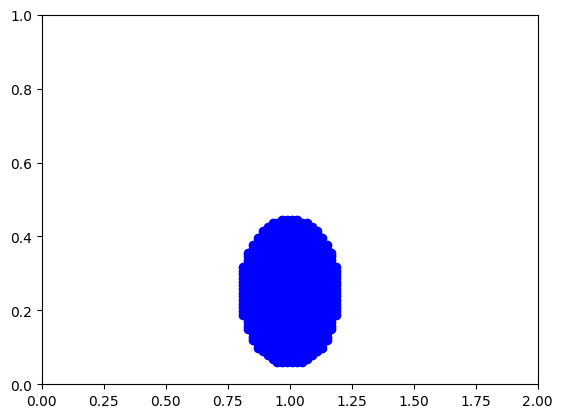

In [8]:
#Plot the 3D Periodic Thickening of X sliced along the z axis
reeb.plot_res_grid()

In [9]:
# Compute Circular Max-Flow
try:
    flow = circular_max_flow(reeb)*(reeb.unit_2d)
except:
    flow=0

flow

0.11841976276835603

# Max-Flow and Point Processes

We sample point processes from different families (Poisson, Matern Repulsive, Matern Clustering) in a window. 
We apply periodic boundary conditions on the window and use circular max-flow to distinguish between the different families.

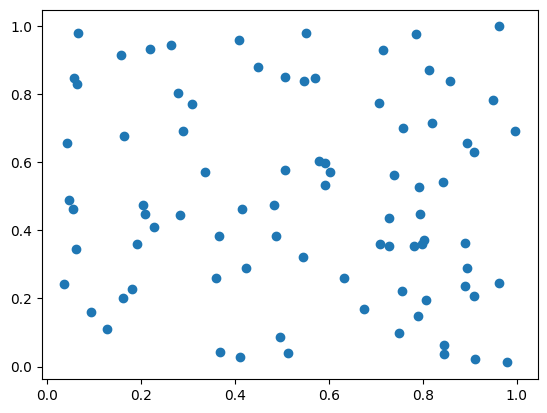

In [10]:
# Poisson

X = poisson(100,dim=2)

plt.scatter(X[:,0],X[:,1])

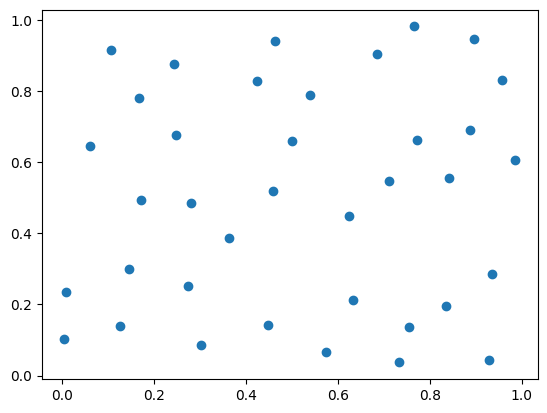

In [11]:
# Matern Repulsive

X = matern_rep(100,0.1,dim=2)

plt.scatter(X[:,0],X[:,1])

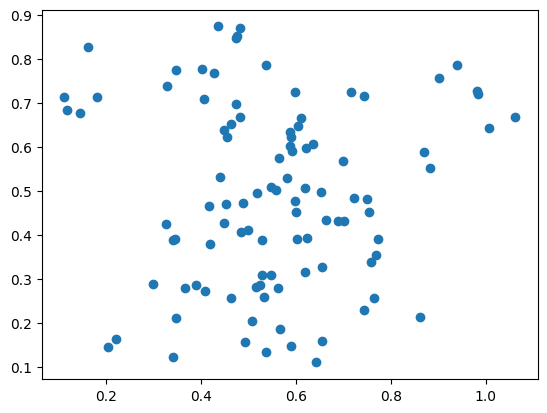

In [12]:
# Matern Clustering

X = matern_clust(20,5,0.2,dim=2)

plt.scatter(X[:,0],X[:,1])

In [13]:
# Setting up the parameters for building the Reeb Graphs

n_grid = 101 # number of point in each dimension for the grid
r_grid = np.linspace(0.01,0.25,40) # grid for thickening the points and fitting the reeb graphs


# don't change the following
fat = 1
covering = np.array([-1,1])
reeb_stride = 2
relax = [n_grid//2,-(n_grid//2+1)]
stride = 20
M = np.array([1,1,1],dtype=float)
m = np.array([0,0,0],dtype=float)




In [14]:
F = []
colors = ['b','r','g']
labels = ['CSR','Repulsive','Cluster']

c = []
        
for count in range(20):
    for i in [0,1,2]:

        f = np.zeros_like(r_grid)

        if i ==0:
            X = poisson(200)
        elif i==1:
            X = matern_rep(400,0.1)
        else:
            X = matern_clust(20,10,0.2)

        radii = np.ones_like(X[:,0])

        for j,k in enumerate(r_grid):

            r = radii*k 

            reeb = Reeb_Graph(X, M = M, m = m, radii = r,
                grid_size = n_grid, 
                periodic = True,
                fat_radius = fat,
                covering = covering,
                reeb_stride = reeb_stride,
                transform_points = None,
                relax_z_axis = relax,
                verbose = False, save_RAM = True, stride=stride, MP=False)

            if reeb.res_grid is not None:
                reeb.make_reeb_graph(plot=False)
                try:
                    flow = circular_max_flow(reeb)*(reeb.unit_2d)
                except:
                    flow=0
            else: 
                flow = 0

            print('Reeb Graph Done! Iteration:',count,'Class: ',i,'Grid element: ', j,'       ',end='\r')

            f[j] = flow

        F.append(f)
        c.append(colors[i])

In [15]:
#np.save('colors',colors)
#np.save('F',F)

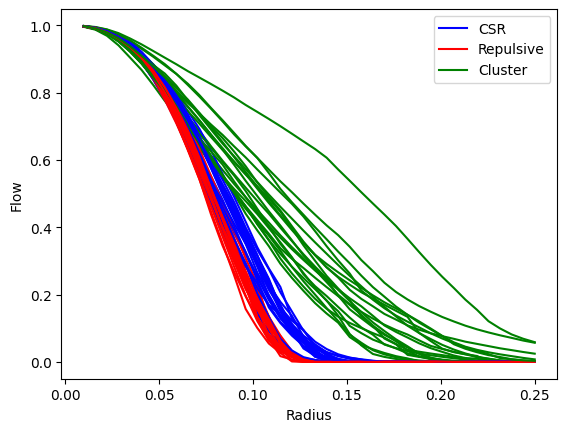

In [16]:
b = 0
r = 0
g = 0

for j,f in enumerate(F):
    
    if b==0 and c[j]=='b':
        plt.plot(r_grid,f,c=c[j], label='CSR')
        b+=1
    elif r==0 and c[j]=='r':
        plt.plot(r_grid,f,c=c[j], label='Repulsive')
        r+=1
    elif g==0 and c[j]=='g':
        plt.plot(r_grid,f,c=c[j], label='Cluster')
        g+=1
    else:    
        plt.plot(r_grid,f,c=c[j])

plt.xlabel('Radius')
plt.ylabel('Flow')
plt.legend()